# <font color = red>Imports</font>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import os
import yaml
import json
import re
import time
import datetime
import random
import pickle

from tqdm import tqdm

import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyOAuth,SpotifyClientCredentials

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# <font color = #1DB954>Connecting to the Spotify API</font>

In [2]:
# Read Spotify credentials from YAML file
with open("./SpotifyToken/SpotifyToken.yaml") as f:
    spotify_config = yaml.safe_load(f)

# Authenticate Spotify client using credentials
auth = SpotifyClientCredentials(client_id = spotify_config['client_id'], client_secret = spotify_config['client_secret'])
sp = spotipy.Spotify(auth_manager = auth)

# <font color = #B629E4>I. Getting The Data</font>

The data we're dealing with was taken from the [Spotify Million Playlist Dataset Challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge/dataset_files) on **Aicrowd**, that contains 1M playlists under json format. We will be working on the first 50 files only since the data is huge and very memory consuming to work with.

## 1. JSON to CSV extraction

In [ ]:
path = 'Data/SMD/'
def get_unique_tracks(path, num):
    playlists = []
    uniqueTracks = pd.DataFrame()
    filenames = os.listdir(path)
    for fname in tqdm(sorted(filenames, key = len)):
        with open(os.path.join(path, fname)) as f:
            current = json.load(f)
            playlists.extend(current['playlists'])
            temp = pd.DataFrame(playlists).explode('tracks')['tracks'].apply(pd.Series).reset_index(drop=True)
            uniqueTracks = pd.concat([uniqueTracks, temp], axis = 0)
            uniqueTracks.drop_duplicates(subset = ['track_uri'], inplace = True)
            playlists = []
        num -=1
        if num == 0:
            break
    return uniqueTracks

df = get_unique_tracks(path, 50)
df.to_csv('data/1-Extraction.csv')

## 2. Cleaning the data

In [39]:
df = pd.read_csv('Data/1-Extraction.csv')

In [40]:
print("Columns: ", df.columns)
print("Length: ", len(df.columns))

Columns:  Index(['Unnamed: 0', 'pos', 'artist_name', 'track_uri', 'artist_uri',
       'track_name', 'album_uri', 'duration_ms', 'album_name'],
      dtype='object')
Length:  9


Keeping only the uri

In [38]:
cols_to_process = ["track_uri", "artist_uri", "album_uri"]
for col in cols_to_process:
    df[col] = df[col].apply(lambda x: re.findall(r'\w+$', x)[0])

Dropping unwanted columns and saving the new data into a new csv

In [39]:
# Keep only the columns ['track_uri', 'artist_uri', 'album_uri']
df.drop(df.columns.difference(['track_uri', 'artist_uri', 'album_uri']), 1, inplace = True)

# Renaming the columns to capital start letters
df.columns = ['Track_Uri', 'Artist_Uri', 'Album_Uri']

# Saving the new DataFrame to a new CSV file
df.to_csv('Data/2-Cleaning.csv', index = False)

<ipython-input-39-b43d80cbacc1>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(['track_uri', 'artist_uri', 'album_uri']), 1, inplace=True)


In [95]:
df = pd.read_csv('Data/2-Cleaning.csv')

In [96]:
print("Columns: ", df.columns)
print("Length: ", len(df.columns))

Columns:  Index(['Track_Uri', 'Artist_Uri', 'Album_Uri'], dtype='object')
Length:  3


## 3. Extracting Features

Now here we will use the spotify api in order to get the audio features, track features, and artist features for each track

In [97]:
tUri = df["Track_Uri"].unique()
aUri = df["Artist_Uri"].unique()

#### a. Audio features

In [98]:
with open('Data/3-AudioFeatures.csv','a') as f, open("Logs/AudioFeatures.txt", "a") as r:
    err = 0
    for i in tqdm(range(0,len(tUri),100)):
        try:
            audioFeatures = sp.audio_features(tUri[i:i+100])
            dataFrame = pd.DataFrame(audioFeatures)
            csv = dataFrame.to_csv(header = False, index = False)
            f.write(csv)
        except Exception as error:
            err+=1
            r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+": "+str(error)+'\n')
            time.sleep(3)
            continue
    r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+"Total Number Of Errors : " + str(err)+'\n')

100%|██████████| 4619/4619 [16:45<00:00,  4.59it/s]


#### Adding column names

In [99]:
af = open('Data/3-AudioFeatures.csv')
df = pd.read_csv(af)
df.columns = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature']
df.to_csv('Data/3-AudioFeatures.csv')

#### b. Track features

In [101]:
with open('Data/4-TrackFeatures.csv','a') as f, open("Logs/TrackFeatures.txt", "a") as r:
    err = 0
    for i in tqdm(range(0,len(tUri),50)):
        try:
            trackFeatures = sp.tracks(tUri[i:i+50])
            for x in range(50):
                dataFrame = pd.DataFrame([tUri[i+x]],columns = ['Track_uri'])
                dataFrame['release_date']=trackFeatures['tracks'][x]['album']['release_date']
                dataFrame['pop'] = trackFeatures['tracks'][x]["popularity"]
                csv = dataFrame.to_csv(header = False, index = False)
                f.write(csv)
        except Exception as error:
            err+=1
            r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+": "+str(error)+'\n')
            time.sleep(3)
            continue
    r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+"Total Number Of Errors : " + str(err)+'\n')

100%|██████████| 9238/9238 [50:31<00:00,  3.05it/s]  


#### Adding column names

In [102]:
tf = open('Data/4-TrackFeatures.csv')
df = pd.read_csv(tf)
df.columns = ['Track_Uri','release_date','pop']
df.to_csv('Data/4-TrackFeatures.csv')

#### c. Artist Features

In [103]:
with open('Data/5-ArtistFeatures.csv','a') as f, open("Logs/ArtistFeatures.txt", "a") as r:
    err = 0
    for i in tqdm(range(0,len(aUri),50)):
        try:
            artistFeatures = sp.artists(aUri[i:i+50])
            for x in range(50):
                dataFrame = pd.DataFrame([aUri[i+x]],columns = ['Artist_uri'])
                artistPop = artistFeatures['artists'][x]["popularity"]
                artistGenres = artistFeatures['artists'][x]["genres"]
                dataFrame["artist_pop"] = artistPop
                if artistGenres: 
                    dataFrame["genres"] = " ".join([re.sub(' ','_',i) for i in artistGenres])
                else:
                  dataFrame["genres"] = "unknown"
                csv = dataFrame.to_csv(header = False, index = False)
                f.write(csv)
        except Exception as error:
            err+=1
            r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+": "+str(error)+'\n')
            time.sleep(3)
            continue
    r.write(datetime.datetime.now().strftime("%d.%b %Y %H:%M:%S")+"Total Number Of Errors : " + str(err)+'\n')

100%|██████████| 1610/1610 [04:58<00:00,  5.39it/s]


#### Adding column names

In [104]:
af = open('Data/5-ArtistFeatures.csv')
df = pd.read_csv(af)
df.columns = ['Artist_Uri','artist_pop','genres']
df.to_csv('Data/5-ArtistFeatures.csv')

#### Saving the csvs into variables

In [105]:
audioF = pd.read_csv('Data/3-AudioFeatures.csv')
trackF = pd.read_csv('Data/4-TrackFeatures.csv')
artistF = pd.read_csv('Data/5-ArtistFeatures.csv')

# <font color = #B629E4>II. Cleaning The Data</font>

Cleaning the data is an important step in the data preprocessing process, as it ensures that the data is in a format that can be easily and effectively analyzed and used to train machine learning models.

Dropping unwanted column

In [106]:
for df in [audioF, trackF, artistF]:
    df.drop(columns = ['Unnamed: 0'], inplace = True)

In [107]:
audioF.columns, artistF.columns, trackF.columns

(Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
        'time_signature'],
       dtype='object'),
 Index(['Artist_Uri', 'artist_pop', 'genres'], dtype='object'),
 Index(['Track_Uri', 'release_date', 'pop'], dtype='object'))

Saving them back without index

In [108]:
audioF.to_csv('Data/3-AudioFeatures.csv', index = False)
trackF.to_csv('Data/4-TrackFeatures.csv', index = False)
artistF.to_csv('Data/5-ArtistFeatures.csv', index = False)

### 1. Merging the 3 files with the 2-Cleaning.csv file 

In [109]:
df = pd.read_csv('Data/2-Cleaning.csv')

In [110]:
df = pd.merge(df, audioF, left_on = "Track_Uri", right_on = "id", how = 'outer')
df = pd.merge(df, trackF, left_on = "Track_Uri", right_on = "Track_Uri", how = 'outer')
df = pd.merge(df, artistF, left_on = "Artist_Uri", right_on = "Artist_Uri", how = 'outer')

In [111]:
df.to_csv('Data/6-Merged.csv', index = False)

### 2. Handling missing data

In [15]:
df = pd.read_csv('Data/6-Merged.csv')

In [16]:
df.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'release_date', 'pop',
       'artist_pop', 'genres'],
      dtype='object')

In [17]:
df.shape

(461880, 25)

In [6]:
df.isna().sum()

Track_Uri              0
Artist_Uri             0
Album_Uri              0
danceability         601
energy               601
key                  601
loudness             601
mode                 601
speechiness          601
acousticness         601
instrumentalness     601
liveness             601
valence              601
tempo                601
type                 601
id                   601
uri                  601
track_href           601
analysis_url         601
duration_ms          601
time_signature       601
release_date        1503
pop                 1503
artist_pop            89
genres                89
dtype: int64

Dropped all rows containing null values

In [10]:
df.dropna(axis = 0, inplace = True)

In [11]:
df.isna().sum()

Track_Uri           0
Artist_Uri          0
Album_Uri           0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
release_date        0
pop                 0
artist_pop          0
genres              0
dtype: int64

In [12]:
df.shape

(459689, 25)

In [13]:
#save into csv file
df.to_csv('Data/7-MergedFull.csv', index = False)

Checking if there's still null values

In [19]:
df.isna().sum().sum() # perfect

0

In [20]:
df.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'release_date', 'pop',
       'artist_pop', 'genres'],
      dtype='object')

In [21]:
df.columns = ['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Type', 'Id', 'Uri', 'Track_Href',
       'Analysis_Url', 'Duration(ms)', 'Time_Signature', 'Track_Release_Date', 'Track_Pop', 'Artist_Pop', 'Artist_Genres']

In [22]:
df.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Type', 'Id', 'Uri', 'Track_Href',
       'Analysis_Url', 'Duration(ms)', 'Time_Signature', 'Track_Release_Date',
       'Track_Pop', 'Artist_Pop', 'Artist_Genres'],
      dtype='object')

Dropping unwanted columns

In [23]:
df.drop(columns = ['Type', 'Id', 'Uri', 'Track_Href', 'Analysis_Url'], axis = 1, inplace = True)

In [24]:
df.to_csv('Data/7-MergedFull.csv', index = False)

### 3. Preprocessing data

 The purpose of these steps are to ensure that all the features of the data have the same scale and range of values. This is important because some machine learning algorithms are sensitive to the scale of the input features, and if the features have different scales, it can affect the performance of the model.

In [25]:
df = pd.read_csv('Data/7-MergedFull.csv')

In [26]:
df[['Track_Pop','Artist_Pop']] = df[['Track_Pop','Artist_Pop']].apply(lambda x: x/5).apply(np.floor)

b. Release date reformating and scaling

In [27]:
df['Track_Release_Date'] = df['Track_Release_Date'].apply(lambda x: int(x.split('-')[0])//50)

In [28]:
df.head()

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Artist_Genres
0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,198800.0,4.0,40,16.0,16.0,dance_pop pop
1,4DZpzJhrt8SG22hsyruUB1,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.657,0.645,2.0,-6.520,0.0,0.0603,0.00592,0.000199,0.2360,0.658,91.988,198640.0,4.0,40,0.0,16.0,dance_pop pop
2,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.701,0.700,7.0,-6.672,0.0,0.0925,0.14600,0.000000,0.2060,0.592,122.984,230960.0,4.0,40,0.0,16.0,dance_pop pop
3,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4,5PmgtkodFl2Om3hMXONDll,0.765,0.791,8.0,-5.707,1.0,0.0317,0.26200,0.000154,0.0669,0.966,95.026,206227.0,4.0,40,13.0,16.0,dance_pop pop
4,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4,0oFBaXLFsUVa2gEmJf4FcJ,0.696,0.546,5.0,-6.550,1.0,0.0414,0.00379,0.000004,0.3320,0.787,130.002,210267.0,4.0,40,13.0,16.0,dance_pop pop


In [29]:
df.to_csv('Data/8-ModelNearReady.csv', index = False)

Changing the data types of the columns to more memory-efficient options, such as 'float16' or 'int8', can help to reduce the amount of memory required to store the DataFrame.

In [30]:
path = 'Data/8-ModelNearReady.csv'

dtypes = {'Track_Uri': 'object', 'Artist_Uri': 'object', 'Album_Uri': 'object', 'Danceability': 'float16', 'Energy': 'float16', 'Key': 'float16',
               'Loudness': 'float16', 'Mode': 'float16', 'Speechiness': 'float16', 'Acousticness': 'float16', 'Instrumentalness': 'float16',
               'Liveness': 'float16', 'Valence': 'float16', 'Tempo': 'float16', 'Duration_ms': 'float32', 'Time_Signature': 'float16',
               'Track_Release_Date': 'int8', 'Track_Pop': 'int8', 'Artist_Pop': 'int8', 'Artist_genres': 'object'}

df = pd.read_csv(path, dtype = dtypes)

In [31]:
df.dtypes

Track_Uri              object
Artist_Uri             object
Album_Uri              object
Danceability          float16
Energy                float16
Key                   float16
Loudness              float16
Mode                  float16
Speechiness           float16
Acousticness          float16
Instrumentalness      float16
Liveness              float16
Valence               float16
Tempo                 float16
Duration(ms)          float64
Time_Signature        float16
Track_Release_Date       int8
Track_Pop                int8
Artist_Pop               int8
Artist_Genres          object
dtype: object

In [32]:
num_unique_rows = len(df.nunique(axis = 1))
print("Number of unique rows = ", num_unique_rows)

Number of unique rows =  459689


In [33]:
df.to_csv('Data/9-ModelReady.csv', index = False)

In [4]:
df = pd.read_csv('Data/9-ModelReady.csv')

This is the fial csv that we will be using for the recommendation (Songs.csv)

In [5]:
df.to_csv('Data/Songs.csv', index = False)

# <font color = #B629E4>III. Modeling</font>

Content-based filtering is a method of recommending items to users based on their past preferences and interests. It utilizes the features or characteristics of the items being recommended, such as the genre, artist, or lyrics of a song, to determine how similar they are to the user's past preferences. 

The basic idea behind this method is that the items that are similar to the items that a user has liked in the past will also be liked by the user. It's considered a simple form of Machine Learning, as it uses data about the item and the user's past preferences to make a prediction about which items the user is likely to like in the future.

Cosine similarity is a measure of similarity between two non-zero vectors, it calculates the cosine of the angle between them. It's used to find the similarity between the user profile, which is created based on their past preferences and the feature vectors of each song. It ranges from -1 to 1, with 1 indicating identical direction and 0 indicating orthogonality (perpendicularity), and -1 meaning they are totally different.

## 1. Testing Spotify Recommendations

<iframe src="https://open.spotify.com/embed/track/2akrIna6A1btLmjPBN8YKI" width="100%" height="380" frameBorder="0" allowtransparency="true" allow="encrypted-media" data-external="1"></iframe>



### Getting the track's uri only

In [10]:
url = 'https://open.spotify.com/track/2akrIna6A1btLmjPBN8YKI?si=56888d9ac3b54b1f'
uri = url.rsplit('/', 1)[-1].split('?')[0]

print(uri)

2akrIna6A1btLmjPBN8YKI


### Spotify's recommendations

In [11]:
result =[]
sm = sp.recommendations(seed_tracks = [uri], limit = 25)
result = [(re.findall(r'\w+$', track['id'])[0], re.findall(r'\w+$', track['uri'])[0], re.findall(r'\w+$', track['artists'][0]['uri'])[0]) for track in sm['tracks'][:25]]

# create an empty DataFrame
sr = pd.DataFrame(columns = ['Track_Name', 'Artist_Name', 'Track_Uri', 'Artist_Uri'])

# loop through the result list and add the track name and artist name to the DataFrame
for track_id, track_uri, artist_uri in result:
    track_name = sp.track(track_id)['name']
    artist_name = sp.track(track_id)['artists'][0]['name']
    temp_df = pd.DataFrame({'Track_Name': [track_name], 'Artist_Name': [artist_name], 'Track_Uri': [track_uri], 'Artist_Uri': [artist_uri]})
    sr = pd.concat([sr, temp_df], ignore_index = True)

sr

,Track_Name,Artist_Name,Track_Uri,Artist_Uri
0,Now You're Gone,Vion Konger,0thGZdI6gOd7C9nF9uzGc5,30IONe5gqXy6MXSNHVCCYP
1,Dancing In The Moonlight (feat. NEIMY) - PBH &...,Jubël,2E82VLSCocIcymHDHoMHyr,4FcZfItjVIsfO9TynErl7X
2,Don’t Wake Me Up,Jonas Blue,3LEgGAl9zLcQWGTp7ptqtQ,1HBjj22wzbscIZ9sEb5dyf
3,Again,Keanu Silva,16HrOASfb75oNM5AcQV9Fh,1zLMhO4zzzxt5PMV4wMS3y
4,Can’t Wait For You,Deanz,3bFMYgcEw3vneqFQOXkaJH,0gptxPtZ8qjNwdgszJzLNN
5,Used To,Hogland,70QyATpmT1mt7JMeDzrInv,5s21IKPvmxRf9WxpO8H5UB
6,So Good to Me,ARTY,5E5dmDcvh5lrPdqsX1OWL1,1rSGNXhhYuWoq9BEz5DZGO
7,Sway My Way (with Amy Shark) - Karim Naas Remix,R3HAB,37BaqZs2MbSYHFbwzIUADM,6cEuCEZu7PAE9ZSzLLc2oQ
8,Dancing’s Done,Ava Max,06yG42F8p8l621YLki0rp2,4npEfmQ6YuiwW1GpUmaq3F
9,Queen On A Throne,Junge Junge,4jHHAzGq4r6i6UtSpWWs4X,721T2PETMLaAkijbYu05VD


## 2. Testing Our Model's Recommendations

### Getting audio features

In [12]:
audio_ = pd.DataFrame(sp.audio_features([uri]))
# Create a dictionary of old and new column names
new_column_names = {'danceability': 'Danceability', 'energy': 'Energy', 'key': 'Key',
                    'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
                    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
                    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
                    'type': 'Type', 'id': 'Id', 'uri': 'Uri', 'track_href': 'Track_Href',
                    'analysis_url': 'Analysis_Url', 'duration_ms': 'Duration(ms)',
                    'time_signature': 'Time_Signature', 'track_release_date': 'Track_Release_Date'}

audio_.rename(columns = new_column_names, inplace = True)
audio_.drop(columns = ['Type', 'Uri', 'Track_Href', 'Analysis_Url'], axis = 1, inplace = True)

audio_

,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Id,Duration(ms),Time_Signature
0,0.66,0.801,4,-5.018,0,0.0273,0.0407,0.000002,0.454,0.53,120.064,2akrIna6A1btLmjPBN8YKI,168197,4


### Getting track features

In [14]:
track_features = sp.tracks([uri])

track_ = pd.DataFrame()

track_pop = pd.DataFrame(columns=['Track_Uri', 'Track_Release_Date', 'Track_Pop', 'Artist_Uri', 'Album_Uri'])
track_pop.loc[0] = [uri, track_features['tracks'][0]['album']['release_date'], track_features['tracks'][0]["popularity"], track_features['tracks'][0]['artists'][0]['id'], track_features['tracks'][0]['album']['id']]
track_ = pd.concat([track_, track_pop], axis = 0)

track_

,Track_Uri,Track_Release_Date,Track_Pop,Artist_Uri,Album_Uri
0,2akrIna6A1btLmjPBN8YKI,2022-06-03,62,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o


### Getting artist features

In [15]:
artist_ = pd.DataFrame()

artist_id = track_['Artist_Uri'][0]
artist_df = pd.DataFrame([artist_id], columns = ['Artist_Uri'])
artist_features = sp.artist(artist_id)
artist_df['Artist_Pop'] = artist_features['popularity']
artist_genres = artist_features['genres']
artist_df["Artist_Genres"] = " ".join([re.sub(' ', '_', i) for i in artist_genres]) if artist_genres else "unknown"
artist_ = pd.concat([artist_, artist_df], axis = 0)

artist_

,Artist_Uri,Artist_Pop,Artist_Genres
0,4FcZfItjVIsfO9TynErl7X,66,dance_pop edm pop pop_dance swedish_pop tropic...


### Merging all 3 features into test

In [16]:
test = pd.DataFrame(track_, columns = ['Track_Uri', 'Artist_Uri', 'Album_Uri'])
test.rename(columns = {'Track_Uri': 'track_uri','Artist_Uri': 'artist_uri', 'Album_Uri': 'album_uri'}, inplace = True)

test = pd.merge(test, audio_, left_on = "track_uri", right_on = "Id", how = 'outer')
test = pd.merge(test, track_, left_on = "track_uri", right_on = "Track_Uri", how = 'outer')
test = pd.merge(test, artist_, left_on = "artist_uri",right_on = "Artist_Uri", how = 'outer')

test

,track_uri,artist_uri,album_uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Duration(ms),Time_Signature,Track_Uri,Track_Release_Date,Track_Pop,Artist_Uri_x,Album_Uri,Artist_Uri_y,Artist_Pop,Artist_Genres
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.66,0.801,4,-5.018,0,0.0273,0.0407,...,168197,4,2akrIna6A1btLmjPBN8YKI,2022-06-03,62,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,4FcZfItjVIsfO9TynErl7X,66,dance_pop edm pop pop_dance swedish_pop tropic...


### Dropping useless columns

In [17]:
test.drop(columns = ['Track_Uri', 'Artist_Uri_x','Artist_Uri_y', 'Album_Uri', 'Id'], axis = 1, inplace = True)

test.rename(columns = {'track_uri': 'Track_Uri','artist_uri': 'Artist_Uri', 'album_uri': 'Album_Uri'}, inplace = True)

In [18]:
test.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration(ms)', 'Time_Signature',
       'Track_Release_Date', 'Track_Pop', 'Artist_Pop', 'Artist_Genres'],
      dtype='object')

In [19]:
test.head()

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Artist_Genres
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.66,0.801,4,-5.018,0,0.0273,0.0407,0.000002,0.454,0.53,120.064,168197,4,2022-06-03,62,66,dance_pop edm pop pop_dance swedish_pop tropic...


In [20]:
test.dtypes

Track_Uri              object
Artist_Uri             object
Album_Uri              object
Danceability          float64
Energy                float64
Key                     int64
Loudness              float64
Mode                    int64
Speechiness           float64
Acousticness          float64
Instrumentalness      float64
Liveness              float64
Valence               float64
Tempo                 float64
Duration(ms)            int64
Time_Signature          int64
Track_Release_Date     object
Track_Pop               int64
Artist_Pop              int64
Artist_Genres          object
dtype: object

### Normalizing 'Track_Pop', 'Artist_Pop', 'Track_Release_Date' for better results

In [21]:
test[['Track_Pop','Artist_Pop']] = test[['Track_Pop','Artist_Pop']].apply(lambda x: x/5).apply(np.floor)
test['Track_Release_Date'] = test['Track_Release_Date'].apply(lambda x: int(str(x).split('-')[0])//50)

In [23]:
test

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Artist_Genres
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.66,0.801,4,-5.018,0,0.0273,0.0407,0.000002,0.454,0.53,120.064,168197,4,40,12.0,13.0,dance_pop edm pop pop_dance swedish_pop tropic...


### Changing types to save memory

In [24]:
test[['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time_Signature']] = test[['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Time_Signature']].astype('float16')
test[['Track_Release_Date', 'Track_Pop', 'Artist_Pop']] = test[['Track_Release_Date', 'Track_Pop', 'Artist_Pop']].astype('int8')

In [25]:
test.dtypes

Track_Uri              object
Artist_Uri             object
Album_Uri              object
Danceability          float16
Energy                float16
Key                   float16
Loudness              float16
Mode                  float16
Speechiness           float16
Acousticness          float16
Instrumentalness      float16
Liveness              float16
Valence               float16
Tempo                 float16
Duration(ms)            int64
Time_Signature        float16
Track_Release_Date       int8
Track_Pop                int8
Artist_Pop               int8
Artist_Genres          object
dtype: object

In [26]:
len(test.columns)

20

In [27]:
test.head()

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Artist_Genres
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.660156,0.800781,4.0,-5.019531,0.0,0.027298,0.04071,0.000002,0.454102,0.529785,120.0625,168197,4.0,40,12,13,dance_pop edm pop pop_dance swedish_pop tropic...


In [28]:
test.to_csv('Data/ModelTest/test.csv', index = False)

### Preparation

The first line of code applies a lambda function to the column 'Artist_Genres' in the test dataframe, which splits each value in the column by a space character and returns a list of the substrings.

The second line of code creates an instance of the TfidfVectorizer class which is a tool from sklearn library that converts a collection of raw documents to a matrix of TF-IDF features. This is used to evaluate how important a word is to a document in a collection or corpus.

The third line of code uses this TfidfVectorizer to create a sparse matrix of the tf-idf scores for each term in the vocabulary and for each document, by joining the list of genres from the 'Artist_Genres' column.
The max_features = 3 in the TfidfVectorizer means that it will only consider the top 3 words in the vocabulary when creating the matrix.

In [29]:
test = pd.read_csv('Data/ModelTest/test.csv')

In [30]:
test['Artist_Genres'] = test['Artist_Genres'].apply(lambda x: x.split(" "))

### TF-IDF Giving weights to the genres

Convert a collection of raw documents to a matrix of TF-IDF features.

In [31]:
tfidf = TfidfVectorizer(max_features = 3)  
tfidf_matrix = tfidf.fit_transform([" ".join(x) for x in test['Artist_Genres']])

In [32]:
tfidf_matrix

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

making columns for each genre

In [33]:
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['Genre' + "|" +i for i in tfidf.get_feature_names()]
genre_df = genre_df.astype('float16')

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
genre_df

,Genre|dance_pop,Genre|edm,Genre|pop
0,0.577148,0.577148,0.577148


combining the columns to the test dataframe and dropping the 'Artist_Genres' column

In [35]:
test.drop(columns = ['Artist_Genres'], inplace = True)
test = pd.concat([test.reset_index(drop = True), genre_df.reset_index(drop = True)], axis = 1)

In [36]:
test

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.66,0.801,4.0,-5.02,0.0,0.0273,0.0407,...,0.53,120.06,168197,4.0,40,12,13,0.577148,0.577148,0.577148


In [37]:
test.to_csv('Data/ModelTest/test.csv', index = False)

### Recommending

In [38]:
dtypes = {'Track_Uri': 'object', 'Artist_Uri': 'object', 'Album_Uri': 'object', 'Danceability': 'float16', 'Energy': 'float16', 'Key': 'float16',
               'Loudness': 'float16', 'Mode': 'float16', 'Speechiness': 'float16', 'Acousticness': 'float16', 'Instrumentalness': 'float16',
               'Liveness': 'float16', 'Valence': 'float16', 'Tempo': 'float16', 'Duration_ms': 'float32', 'Time_Signature': 'float16',
               'Track_Release_Date': 'int8', 'Track_Pop': 'int8', 'Artist_Pop': 'int8', 'Artist_genres': 'object'}
        
# column names
col_name = ['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
'Liveness', 'Valence', 'Tempo', 'Duration(ms)', 'Time_Signature', 'Track_Release_Date', 'Track_Pop', 'Artist_Pop', 'Artist_Genres']

In [39]:
test = pd.read_csv('Data/ModelTest/test.csv')

In [40]:
df = pd.read_csv('Data/Test.csv', dtype = dtypes, names = col_name, header = 0)

In [41]:
test

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.66,0.801,4.0,-5.02,0.0,0.0273,0.0407,...,0.53,120.06,168197,4.0,40,12,13,0.577,0.577,0.577


In [42]:
df

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Artist_Genres
0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,0.773926,0.837891,5.0,-3.914062,0.0,0.114014,0.024902,0.024994,0.241943,0.923828,143.000,198800.0,4.0,40,16,16,dance_pop pop
1,4DZpzJhrt8SG22hsyruUB1,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.657227,0.645020,2.0,-6.519531,0.0,0.060303,0.005920,0.000199,0.235962,0.658203,92.000,198640.0,4.0,40,0,16,dance_pop pop
2,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.701172,0.700195,7.0,-6.671875,0.0,0.092529,0.145996,0.000000,0.206055,0.591797,123.000,230960.0,4.0,40,0,16,dance_pop pop
3,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4,5PmgtkodFl2Om3hMXONDll,0.765137,0.791016,8.0,-5.707031,1.0,0.031708,0.261963,0.000154,0.066895,0.965820,95.000,206227.0,4.0,40,13,16,dance_pop pop
4,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4,0oFBaXLFsUVa2gEmJf4FcJ,0.695801,0.545898,5.0,-6.550781,1.0,0.041412,0.003790,0.000004,0.332031,0.787109,130.000,210267.0,4.0,40,13,16,dance_pop pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459684,5vJOlHCFuVk6vf538ojg7k,4j17MunhClgM12pRdWSERA,0JS0fDvigWxvTjxt23mYuM,0.500000,0.774902,8.0,-4.562500,1.0,0.027893,0.000065,0.741211,0.087585,0.394043,120.000,212830.0,4.0,40,2,0,electrofox shimmer_pop
459685,6qVIpO8deDeTixa0JEaSaV,58USDY6z4KFM2LbI6Jtcb7,2NXyqt1ng0rscdSI9436DW,0.456055,0.439941,8.0,-11.820312,0.0,0.074402,0.271973,0.004532,0.090881,0.372070,93.625,250462.0,4.0,40,3,0,unknown
459686,0KTeKMTxSHOhyyxQseDbQW,2ZNPznehwH3OmykvUcZjek,37GI5itjRSS2aW5IBuIqtq,0.769043,0.797852,7.0,-5.187500,1.0,0.196045,0.037506,0.000000,0.202026,0.299072,140.875,178756.0,4.0,40,0,6,unknown
459687,6eE7ZHpmH2dt8zFtN5Tk6z,1Ssm2znU9MIw5kZYNWJIF4,1pAqthZKGHGjJ0PNXdyH7m,0.831055,0.448975,1.0,-9.140625,1.0,0.271973,0.008347,0.000000,0.244019,0.306885,123.000,191267.0,4.0,40,0,0,unknown


In [43]:
df['Artist_Genres'] = df['Artist_Genres'].apply(lambda x: x.split(" "))
tfidf_matrix = tfidf.transform(df['Artist_Genres'].apply(lambda x: " ".join(x)))
genre_df = pd.DataFrame(tfidf_matrix.toarray())
genre_df.columns = ['Genre' + "|" + i for i in tfidf.get_feature_names_out()]

In [45]:
genre_df

,Genre|dance_pop,Genre|edm,Genre|pop
0,0.707107,0.0,0.707107
1,0.707107,0.0,0.707107
2,0.707107,0.0,0.707107
3,0.707107,0.0,0.707107
4,0.707107,0.0,0.707107
...,...,...,...
459684,0.000000,0.0,0.000000
459685,0.000000,0.0,0.000000
459686,0.000000,0.0,0.000000
459687,0.000000,0.0,0.000000


In [46]:
genre_df = genre_df.astype('float16')
df.drop(columns = ['Artist_Genres'], axis = 1, inplace = True)

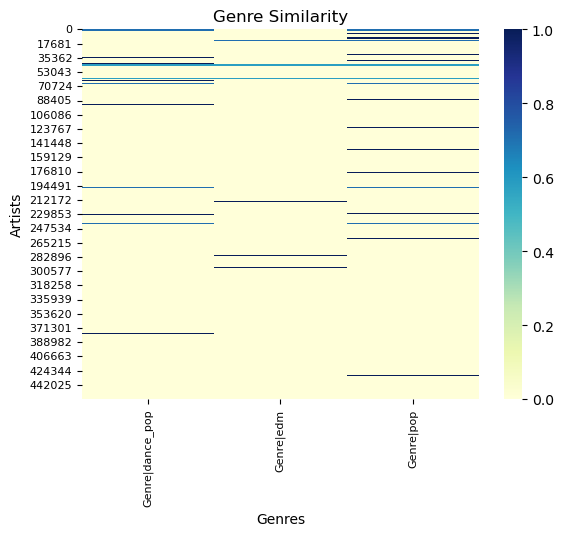

In [47]:
# Create a heatmap using the genre_df DataFrame
sns.heatmap(genre_df, cmap ='YlGnBu')

# Add x-axis and y-axis labels
plt.xlabel('Genres')
plt.ylabel('Artists')

# Add title
plt.title('Genre Similarity')

# Change font size of the tick labels
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

# Rotate x-axis tick labels for readability
plt.xticks(rotation = 90)

# Show the plot
plt.show()

In [48]:
df = pd.concat([df.reset_index(drop = True), genre_df.reset_index(drop = True)], axis = 1)

In [49]:
df

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop
0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,0.773926,0.837891,5.0,-3.914062,0.0,0.114014,0.024902,...,0.923828,143.000,198800.0,4.0,40,16,16,0.707031,0.0,0.707031
1,4DZpzJhrt8SG22hsyruUB1,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.657227,0.645020,2.0,-6.519531,0.0,0.060303,0.005920,...,0.658203,92.000,198640.0,4.0,40,0,16,0.707031,0.0,0.707031
2,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.701172,0.700195,7.0,-6.671875,0.0,0.092529,0.145996,...,0.591797,123.000,230960.0,4.0,40,0,16,0.707031,0.0,0.707031
3,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4,5PmgtkodFl2Om3hMXONDll,0.765137,0.791016,8.0,-5.707031,1.0,0.031708,0.261963,...,0.965820,95.000,206227.0,4.0,40,13,16,0.707031,0.0,0.707031
4,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4,0oFBaXLFsUVa2gEmJf4FcJ,0.695801,0.545898,5.0,-6.550781,1.0,0.041412,0.003790,...,0.787109,130.000,210267.0,4.0,40,13,16,0.707031,0.0,0.707031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459684,5vJOlHCFuVk6vf538ojg7k,4j17MunhClgM12pRdWSERA,0JS0fDvigWxvTjxt23mYuM,0.500000,0.774902,8.0,-4.562500,1.0,0.027893,0.000065,...,0.394043,120.000,212830.0,4.0,40,2,0,0.000000,0.0,0.000000
459685,6qVIpO8deDeTixa0JEaSaV,58USDY6z4KFM2LbI6Jtcb7,2NXyqt1ng0rscdSI9436DW,0.456055,0.439941,8.0,-11.820312,0.0,0.074402,0.271973,...,0.372070,93.625,250462.0,4.0,40,3,0,0.000000,0.0,0.000000
459686,0KTeKMTxSHOhyyxQseDbQW,2ZNPznehwH3OmykvUcZjek,37GI5itjRSS2aW5IBuIqtq,0.769043,0.797852,7.0,-5.187500,1.0,0.196045,0.037506,...,0.299072,140.875,178756.0,4.0,40,0,6,0.000000,0.0,0.000000
459687,6eE7ZHpmH2dt8zFtN5Tk6z,1Ssm2znU9MIw5kZYNWJIF4,1pAqthZKGHGjJ0PNXdyH7m,0.831055,0.448975,1.0,-9.140625,1.0,0.271973,0.008347,...,0.306885,123.000,191267.0,4.0,40,0,0,0.000000,0.0,0.000000


In [50]:
test.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration(ms)', 'Time_Signature',
       'Track_Release_Date', 'Track_Pop', 'Artist_Pop', 'Genre|dance_pop',
       'Genre|edm', 'Genre|pop'],
      dtype='object')

In [51]:
df.columns

Index(['Track_Uri', 'Artist_Uri', 'Album_Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Tempo', 'Duration(ms)', 'Time_Signature',
       'Track_Release_Date', 'Track_Pop', 'Artist_Pop', 'Genre|dance_pop',
       'Genre|edm', 'Genre|pop'],
      dtype='object')

#### Predictions

Here, we are normalizing the values in the columns from index 3 to 19 in the DataFrame "df" by using the MinMaxScaler() method from scikit-learn library. 

t scales the values of the columns between 0 and 1 by subtracting the minimum value of each column and dividing the result by the range of each column (max-min).

The result is stored in the same DataFrame "df".

The scaler object (sc) is then pickled and stored in the Data/sc.sav file so that it can be used later to transform new data using the same scaling parameters.

In [52]:
sc = MinMaxScaler()
df.iloc[:,3:19] = sc.fit_transform(df.iloc[:,3:19])
pickle.dump(sc, open('Data/sc.sav', 'wb'))

Applies the scaling parameters learned from the previous data on the tested data

In [53]:
test.iloc[:,3:19] = sc.transform(test.iloc[:,3:19])

In [54]:
playvec = pd.DataFrame(test)
playvec

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop
0,2akrIna6A1btLmjPBN8YKI,4FcZfItjVIsfO9TynErl7X,3LNntOoLKspcyfwiYpQZ8o,0.665852,0.801,0.363636,0.852765,0.0,0.028238,0.04086,...,0.53,0.484113,0.028548,0.8,1.0,0.631579,0.65,0.577,0.577,0.577


In [55]:
df

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Valence,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop
0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,0.780788,0.837891,0.454545,0.869918,0.0,0.117929,0.025000,...,0.923828,0.576613,0.033805,0.8,1.000,0.842105,0.80,0.707031,0.0,0.707031
1,4DZpzJhrt8SG22hsyruUB1,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.663054,0.645020,0.181818,0.829506,0.0,0.062374,0.005944,...,0.658203,0.370968,0.033777,0.8,1.000,0.000000,0.80,0.707031,0.0,0.707031
2,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.707389,0.700195,0.636364,0.827143,0.0,0.095707,0.146569,...,0.591797,0.495968,0.039329,0.8,1.000,0.000000,0.80,0.707031,0.0,0.707031
3,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4,5PmgtkodFl2Om3hMXONDll,0.771921,0.791016,0.727273,0.842108,1.0,0.032797,0.262990,...,0.965820,0.383065,0.035081,0.8,1.000,0.684211,0.80,0.707031,0.0,0.707031
4,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4,0oFBaXLFsUVa2gEmJf4FcJ,0.701970,0.545898,0.454545,0.829022,1.0,0.042835,0.003805,...,0.787109,0.524194,0.035774,0.8,1.000,0.684211,0.80,0.707031,0.0,0.707031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459684,5vJOlHCFuVk6vf538ojg7k,4j17MunhClgM12pRdWSERA,0JS0fDvigWxvTjxt23mYuM,0.504433,0.774902,0.727273,0.859861,1.0,0.028851,0.000065,...,0.394043,0.483871,0.036215,0.8,1.000,0.105263,0.00,0.000000,0.0,0.000000
459685,6qVIpO8deDeTixa0JEaSaV,58USDY6z4KFM2LbI6Jtcb7,2NXyqt1ng0rscdSI9436DW,0.460099,0.439941,0.727273,0.747289,0.0,0.076957,0.273039,...,0.372070,0.377520,0.042679,0.8,1.000,0.157895,0.00,0.000000,0.0,0.000000
459686,0KTeKMTxSHOhyyxQseDbQW,2ZNPznehwH3OmykvUcZjek,37GI5itjRSS2aW5IBuIqtq,0.775862,0.797852,0.636364,0.850167,1.0,0.202778,0.037653,...,0.299072,0.568044,0.030362,0.8,1.000,0.000000,0.30,0.000000,0.0,0.000000
459687,6eE7ZHpmH2dt8zFtN5Tk6z,1Ssm2znU9MIw5kZYNWJIF4,1pAqthZKGHGjJ0PNXdyH7m,0.838424,0.448975,0.090909,0.788852,1.0,0.281313,0.008379,...,0.306885,0.495968,0.032511,0.8,1.000,0.000000,0.00,0.000000,0.0,0.000000


#### 4. Testing the model

The 'Sim' column represents the cosine similarity between the 'df' DataFrame and the 'playvec' DataFrame after dropping the columns 'Track_Uri', 'Artist_Uri', 'Album_Uri' from both DataFrames.

In [56]:
df['Sim'] = cosine_similarity(df.drop(['Track_Uri', 'Artist_Uri', 'Album_Uri'], axis = 1), playvec.drop(['Track_Uri', 'Artist_Uri', 'Album_Uri'], axis = 1))

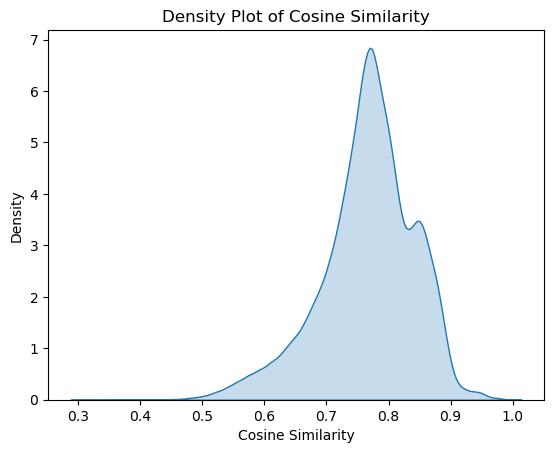

In [57]:
# Create the density plot
sns.kdeplot(df['Sim'], fill = True)

# Add labels and show the plot
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.title('Density Plot of Cosine Similarity')
plt.show()

In [58]:
df

,Track_Uri,Artist_Uri,Album_Uri,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,...,Tempo,Duration(ms),Time_Signature,Track_Release_Date,Track_Pop,Artist_Pop,Genre|dance_pop,Genre|edm,Genre|pop,Sim
0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI,0.780788,0.837891,0.454545,0.869918,0.0,0.117929,0.025000,...,0.576613,0.033805,0.8,1.000,0.842105,0.80,0.707031,0.0,0.707031,0.955622
1,4DZpzJhrt8SG22hsyruUB1,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.663054,0.645020,0.181818,0.829506,0.0,0.062374,0.005944,...,0.370968,0.033777,0.8,1.000,0.000000,0.80,0.707031,0.0,0.707031,0.921760
2,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4,0eXGrEtsH0WVJnqp5imXAs,0.707389,0.700195,0.636364,0.827143,0.0,0.095707,0.146569,...,0.495968,0.039329,0.8,1.000,0.000000,0.80,0.707031,0.0,0.707031,0.921382
3,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4,5PmgtkodFl2Om3hMXONDll,0.771921,0.791016,0.727273,0.842108,1.0,0.032797,0.262990,...,0.383065,0.035081,0.8,1.000,0.684211,0.80,0.707031,0.0,0.707031,0.876953
4,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4,0oFBaXLFsUVa2gEmJf4FcJ,0.701970,0.545898,0.454545,0.829022,1.0,0.042835,0.003805,...,0.524194,0.035774,0.8,1.000,0.684211,0.80,0.707031,0.0,0.707031,0.889829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459684,5vJOlHCFuVk6vf538ojg7k,4j17MunhClgM12pRdWSERA,0JS0fDvigWxvTjxt23mYuM,0.504433,0.774902,0.727273,0.859861,1.0,0.028851,0.000065,...,0.483871,0.036215,0.8,1.000,0.105263,0.00,0.000000,0.0,0.000000,0.699945
459685,6qVIpO8deDeTixa0JEaSaV,58USDY6z4KFM2LbI6Jtcb7,2NXyqt1ng0rscdSI9436DW,0.460099,0.439941,0.727273,0.747289,0.0,0.076957,0.273039,...,0.377520,0.042679,0.8,1.000,0.157895,0.00,0.000000,0.0,0.000000,0.803285
459686,0KTeKMTxSHOhyyxQseDbQW,2ZNPznehwH3OmykvUcZjek,37GI5itjRSS2aW5IBuIqtq,0.775862,0.797852,0.636364,0.850167,1.0,0.202778,0.037653,...,0.568044,0.030362,0.8,1.000,0.000000,0.30,0.000000,0.0,0.000000,0.765259
459687,6eE7ZHpmH2dt8zFtN5Tk6z,1Ssm2znU9MIw5kZYNWJIF4,1pAqthZKGHGjJ0PNXdyH7m,0.838424,0.448975,0.090909,0.788852,1.0,0.281313,0.008379,...,0.495968,0.032511,0.8,1.000,0.000000,0.00,0.000000,0.0,0.000000,0.708862


## Result 

In [64]:
top_artist_tracks = df.groupby('Artist_Uri').head(5).Track_Uri.head(25)
rec = sp.tracks(top_artist_tracks[0:25])
res = pd.DataFrame()

for i in range(25):
    result = pd.DataFrame([i])
    result['Track_Name'] = rec['tracks'][i]['name']
    result['Artist_Name'] = rec['tracks'][i]['artists'][0]['name']
    result['Track_Link'] = rec['tracks'][i]['external_urls']['spotify']
    result['Track_Link'] = result['Track_Link'].apply(lambda x: re.findall(r'\w+$', x)[0])
    result['Artist_Link'] = rec['tracks'][i]['artists'][0]['external_urls']['spotify']
    result['Artist_Link'] = result['Artist_Link'].apply(lambda x: re.findall(r'\w+$', x)[0])
    res = pd.concat([res, result], axis = 0)

    res = res.sample(frac = 1).reset_index(drop = True)
res

,0,Track_Name,Artist_Name,Track_Link,Artist_Link
0,10,Rock Your Body,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7
1,4,I Wanna Go,Britney Spears,5cCAZS9VhLGEDV4NCfieeg,26dSoYclwsYLMAKD3tpOr4
2,19,Angel,Shaggy,6dViIgkYIRccNImPln58rS,5EvFsr3kj42KNv97ZEnqij
3,3,Lucky,Britney Spears,2TTYIwTM2iLC1YOyHuhRMt,26dSoYclwsYLMAKD3tpOr4
4,21,My Boo,Usher,68vgtRHr7iZHpzGpon6Jlo,23zg3TcAtWQy7J6upgbUnj
5,2,Make Me... (feat. G-Eazy),Britney Spears,2ssO8vh0AzVr5zxumbSO7G,26dSoYclwsYLMAKD3tpOr4
6,17,Boom Boom (feat. Shhhean),Shaggy,3DGG8PpaMutQSwRX2H2DBc,5EvFsr3kj42KNv97ZEnqij
7,8,Halo,Beyoncé,2CvOqDpQIMw69cCzWqr5yr,6vWDO969PvNqNYHIOW5v0m
8,15,It Wasn't Me,Shaggy,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij
9,11,Mirrors,Justin Timberlake,4rHZZAmHpZrA3iH5zx8frV,31TPClRtHm23RisEBtV3X7


<iframe src="https://open.spotify.com/embed/track/6JV2JOEocMgcZxYSZelKcc" width="100%" height="380" frameBorder="0" allowtransparency="true" allow="encrypted-media" data-external="1"></iframe>